# Multi-Linear Regression Model for Steam Sales

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import scipy.stats as stats

### Load the data from an Excel file


In [21]:
file_path = 'db_for_model.xlsx'
data = pd.read_excel(file_path)

### Creating Parameters for Model


In [22]:
features = data.drop(columns=['Unnamed: 0', 'appid', 'name', 'developer', 'publisher', 
                              'categories', 'tags', 'genres', 'copies_sold', 'log_copies_sold'])
target = data['copies_sold']
categorical_features = ['publisherclass']
numeric_features = features.drop(columns=categorical_features).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ordinal', OrdinalEncoder())]), categorical_features)
    ])

### Creating Test & Train sets

In [23]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

### Creation of Linear Regression Model with RFE for Feature Selection

In [39]:
model = LinearRegression()
rfe = RFE(estimator=model, n_features_to_select=8)
rfe.fit(X_train_processed, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=8)

### Getting Specific Features for Later

In [40]:
all_feature_names = np.concatenate([numeric_features, categorical_features])
support_mask = rfe.support_
selected_features = all_feature_names[support_mask]

### Fitting Model and Creating Predictions

In [41]:
X_train_selected = X_train_processed[:, support_mask]
X_test_selected = X_test_processed[:, support_mask]
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)

### Summary to Model

In [42]:
X_train_selected_sm = sm.add_constant(X_train_selected)
ols_model = sm.OLS(y_train, X_train_selected_sm).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:            copies_sold   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                 2.545e+04
Date:                Thu, 18 Jul 2024   Prob (F-statistic):               0.00
Time:                        09:54:49   Log-Likelihood:            -6.6560e+05
No. Observations:               50446   AIC:                         1.331e+06
Df Residuals:                   50437   BIC:                         1.331e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.058e+04   2111.762     23.952      0.0

### Getting Specific Metrics for Regression Model

In [43]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
residuals = y_test - y_pred

In [44]:
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 27762.834663862086
Root Mean Squared Error (RMSE): 137927.61035559588
R-squared (R²): 0.7727436939250495


### Plot: Residuals vs Predicted values

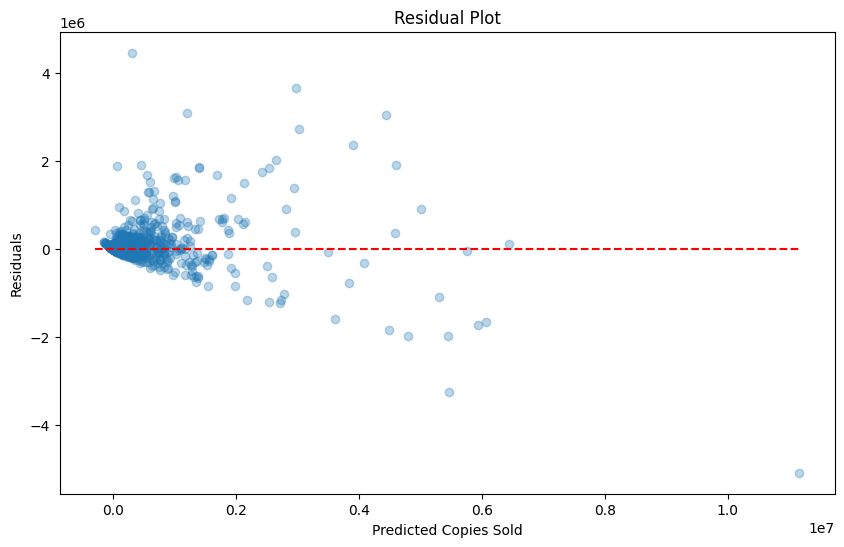

In [45]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.3)
plt.hlines(0, min(y_pred), max(y_pred), colors='red', linestyles='dashed')
plt.xlabel('Predicted Copies Sold')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


### Plot: Histogram of Residuals


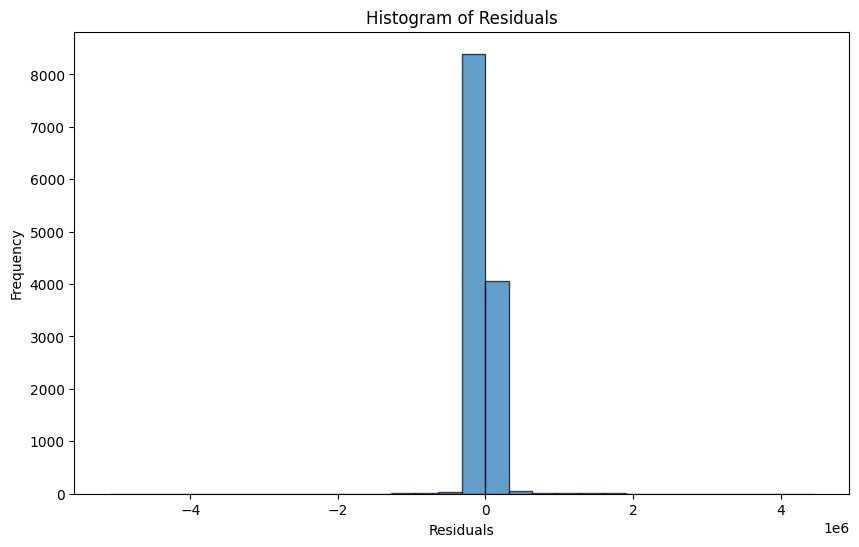

In [46]:
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


# Q-Q Plot Checking Normality of Residuals


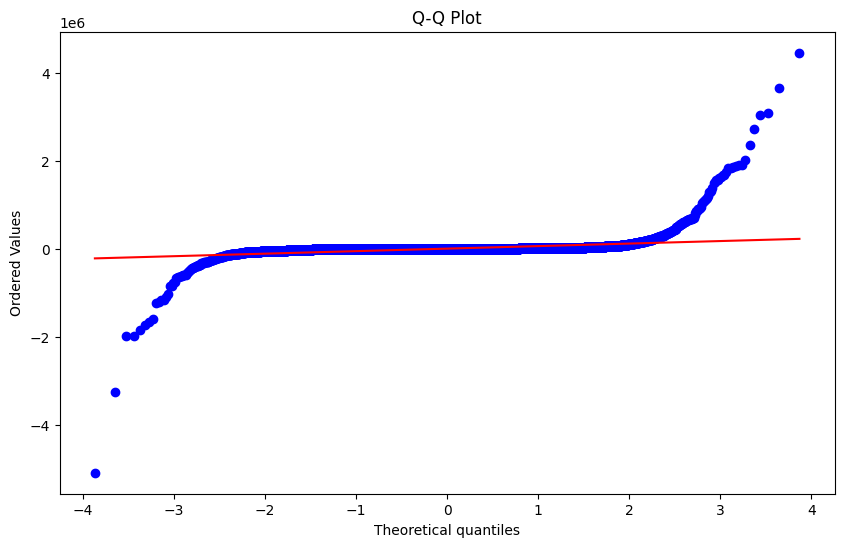

In [47]:
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

### Plot: Actual vs Predicted Copies Sold


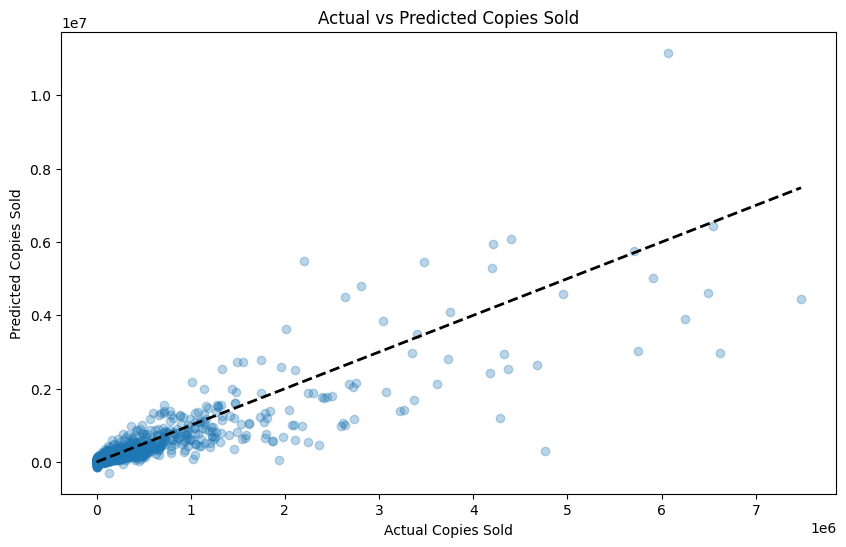

In [48]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Copies Sold')
plt.ylabel('Predicted Copies Sold')
plt.title('Actual vs Predicted Copies Sold')
plt.show()


### Creating Feature Importances to Determine Importance of Feature on Sales

In [49]:
coefficients = model.coef_
feature_importances = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': coefficients
})
feature_importances['Absolute Coefficient'] = feature_importances['Coefficient'].abs()
feature_importances = feature_importances.sort_values(by='Absolute Coefficient', ascending=False)

In [50]:
print(feature_importances)

            Feature    Coefficient  Absolute Coefficient
0          positive  316019.260341         316019.260341
4   recommendations -115810.011596         115810.011596
1          negative   77854.375289          77854.375289
6        peak_users  -14692.034794          14692.034794
2             price  -13888.172127          13888.172127
3  metacritic_score   12088.563436          12088.563436
5     current_users   -8534.254715           8534.254715
7    publisherclass   -1795.299301           1795.299301


### Plot: Feature Importances on Copies Sold


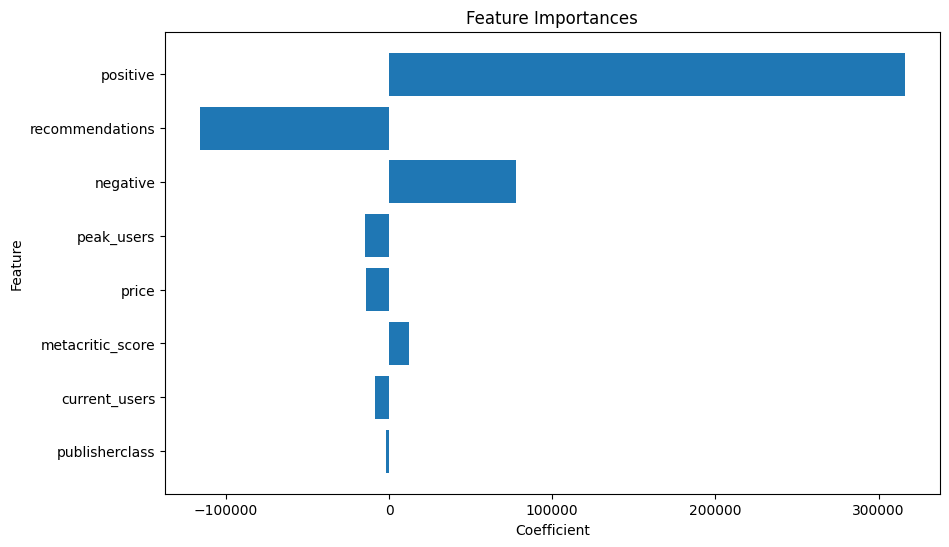

In [51]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Coefficient'])
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()